In [43]:
import torch.nn as nn
import torch.nn.functional as F
import torch as tc
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import random_split

import torch.optim as optim


import pyro.distributions as dist

from tqdm import tqdm

import matplotlib.pyplot as plt

## Creating network

In [44]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 1, 101, stride = 1) # 15000 - 101 + 1 = 14900
        self.pool1 = nn.MaxPool1d(100) # 14900/100 = 149
        
        self.conv2 = nn.Conv1d(1, 1, 10) # 149 - 10 + 1 = 140
        self.pool2 = nn.MaxPool1d(10)# 140/10 = 14
        
        self.fc1 = nn.Linear(14, 1)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = tc.flatten(x, 1)
        x = tc.sigmoid(self.fc1(x))
        return x

net = Net()

In [45]:
print(net)

Net(
  (conv1): Conv1d(1, 1, kernel_size=(101,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=100, stride=100, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(1, 1, kernel_size=(10,), stride=(1,))
  (pool2): MaxPool1d(kernel_size=10, stride=10, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=14, out_features=1, bias=True)
)


## Generate training/testing sets

In [46]:
# This is the model to generate x & y for training

num_samples = 10000

def model_Normal(sd_multiplyer, num_samples):
    signal = tc.sin(tc.linspace(1, 1e10, 15000)).repeat(num_samples, 1)
    noise = dist.Normal(tc.tensor(0.).repeat(num_samples, 1), tc.tensor(1.).repeat(num_samples, 1)).sample()
    return(tc.add(signal, noise))

In [47]:
labels = []
series = []
for _ in range(num_samples):
    label = dist.Bernoulli(0.5).sample()
    labels.append(label)

    if tc.equal(label, tc.tensor(0.)):
        series.append(model_Normal(1, 1))
    else:
        series.append(model_Normal(1.2, 1))

In [48]:
class CustomSeriesLoader(Dataset):
    def __init__(self, series, labels):
        self.series = series
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return tc.reshape(self.series[idx], [1, 1, 15000]), tc.reshape(self.labels[idx], [1,1])

In [49]:
data_loader = CustomSeriesLoader(series, labels)

In [50]:
training_len = 6000
testing_len = num_samples - training_len

In [51]:
train, test = random_split(data_loader, [training_len, testing_len], generator= tc.Generator().manual_seed(42))

In [52]:
# Not used, need to modify the batch size
# train_dataloader = DataLoader(train, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(test, batch_size=64, shuffle=True)

## Optimizer setup

In [53]:
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [74]:
optimization_trace = []
epoch_trace = []
running_loss = 0.
net.train()


for _ in range(10): # num of epoch
    
    epoch_correct = 0

    for i, data in enumerate(train, 0):

        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # predict labels
        outputs = net(inputs)
        pred_label = tc.tensor(0.) if tc.le(outputs, tc.tensor(0.5)) else tc.tensor(1.)
        if pred_label == labels: epoch_correct += 1
        
        # loss and step
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Record runs
        running_loss += loss.item()
        optimization_trace.append(running_loss)


    epoch_trace.append(epoch_correct/training_len)
        

In [75]:
epoch_trace

[0.5035,
 0.5035,
 0.5035,
 0.5035,
 0.5035,
 0.5035,
 0.5035,
 0.5035,
 0.5035,
 0.5035]

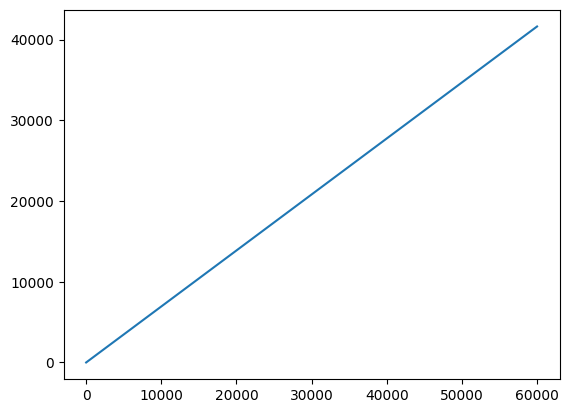

In [76]:
plt.plot(optimization_trace)

In [78]:
acc = 0
net.eval()
with tc.no_grad():
    for i, data in enumerate(train, 0):
        inputs, labels = data
        outputs = net(inputs)
        pred_label = tc.tensor(0.) if tc.le(outputs, tc.tensor(0.5)) else tc.tensor(1.)
        if pred_label == labels: acc += 1
print(acc/testing_len)

0.7625
